In [ ]:
# Preprosesing 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
from libs import utils 

/home/stanlee321/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stanlee321/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stanlee321/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stanlee321/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [277]:
import cv2
import glob

path = "./cuts/partidos/numbers/i_letter"


filenames = glob.glob(f"{path}/*.jpg")



In [150]:
# Some Preprocess
BINARY_THREHOLD = 180

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img,BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smocoth_numpy(image_np):
    img = image_np.copy()

    img = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    h,w = img.shape
    #img[img <128] = 0
    #img = img[int(w*0.2): int(w*0.9),int(h*0.2): int(h*0.9)] 

    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    
    or_image = cv2.cvtColor(or_image, cv2.COLOR_GRAY2BGR)

    return or_image

def remove_red_color_numpy(image_np):
    
    img = image_np.copy()
    
    lower = np.array((90 - 60, 70, 50))  #-- Lower range --
    upper = np.array((90 + 60, 255, 255))  #-- Upper range 
    
    mask = cv2.inRange(img, lower, upper)
    
    res = cv2.bitwise_and(img, img, mask= mask)  #-- Contains pixels having the gray color--
    #res[mask == 255] = (255, 255, 255)
    res = cv2.bitwise_not(res)
    return res

def convert_to_gray(image_np):
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    
    return image_gray

def remove_color_and_add_filter(numpy_i):
    return remove_noise_and_smocoth_numpy(remove_red_color_numpy(numpy_i))


In [305]:
def read_dataframe(filenames_list, samples):
    
    # Read every filename as an RGB image
    imgs = [plt.imread(fname)[..., :3] for fname in filenames_list[:samples]]

    # Crop every image to a square
    imgs_or = [utils.imcrop_tosquare(img_i) for img_i in imgs]

    # Then resize the square image to 100 x 100 pixels
    imgs = [resize(img_i, (100, 100)) for img_i in imgs_or]

    imgs_p = [resize(remove_color_and_add_filter(img_i), (100, 100)) for img_i in imgs_or]


    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    imgs = np.array(imgs).astype(np.float32)

    imgs_p = np.array(imgs_p[:]).astype(np.float32)

    print(imgs.shape)
    print(imgs_p.shape)
    
    return imgs, imgs_p

def read_final_data(filenames_list, samples):
    
    # Read every filename as an RGB image
    imgs = [plt.imread(fname)[..., :3] for fname in filenames_list[:samples]]
    # Crop every image to a square
    imgs_or = [utils.imcrop_tosquare(img_i) for img_i in imgs]
    
    imgs_p = [resize(convert_to_gray(remove_color_and_add_filter(img_i)), (100, 100)) for img_i in imgs_or]
    
    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    imgs_p = np.array(imgs_p[:]).astype(np.float32)

    print(imgs_p.shape)
    
    return imgs_p

In [286]:
imgs, imgs_p = read_dataframe(filenames, 100)

(100, 100, 100, 3)
(100, 100, 100, 3)


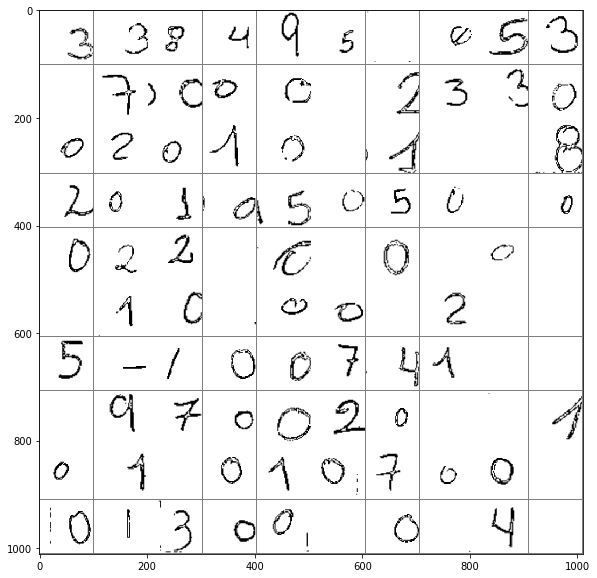

In [287]:
# Plot the resulting dataset:
# Make sure you "run" this cell after you create your `imgs` variable as a 4-D array!
# Make sure we have a 100 x 100 x 100 x 3 dimension array
assert(imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs_p, saveto='dataset_p.png'))


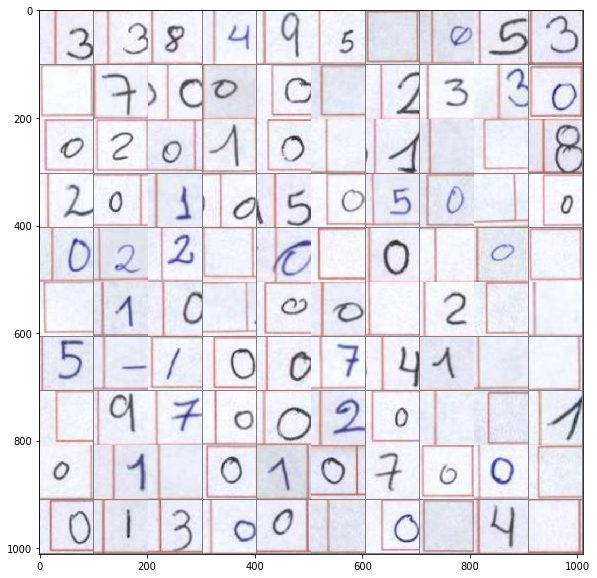

In [154]:

# Plot the resulting dataset:
# Make sure you "run" this cell after you create your `imgs` variable as a 4-D array!
# Make sure we have a 100 x 100 x 100 x 3 dimension array
assert(imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs, saveto='dataset.png'))



In [155]:
data = np.array(imgs)
data_p = np.array(imgs_p)
print(data.shape)
print(data_p.shape)

(100, 100, 100, 3)
(100, 100, 100, 3)


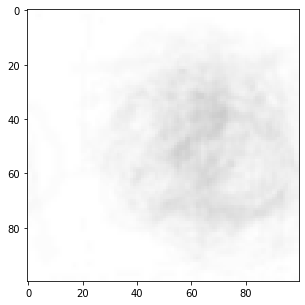

In [157]:
mean_img = np.mean(data_p, axis=0)
# Then plot the resulting mean image:
# Make sure the mean image is the right size!
assert(mean_img.shape == (100, 100, 3))
plt.figure(figsize=(5, 5))
plt.imshow(mean_img)
plt.imsave(arr=mean_img, fname='mean.png')



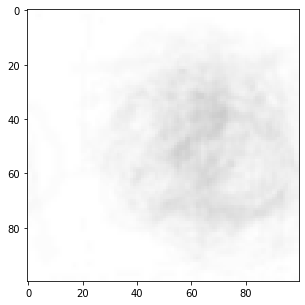

In [158]:
mean_img_p = np.mean(data_p, axis=0)
# Then plot the resulting mean image:
# Make sure the mean image is the right size!
assert(mean_img.shape == (100, 100, 3))
plt.figure(figsize=(5, 5))
plt.imshow(mean_img_p)
plt.imsave(arr=mean_img_p, fname='mean_p.png')



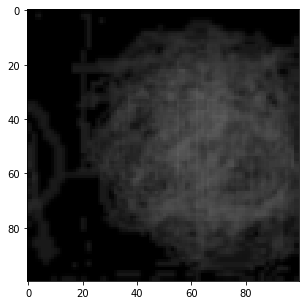

In [159]:
plt.figure(figsize=(5, 5))
std_img = np.std(data_p, axis=0)
plt.imshow(std_img)

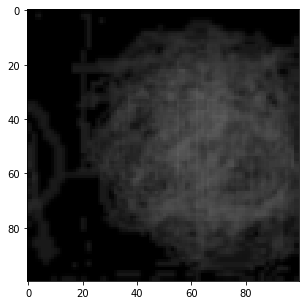

In [160]:
plt.figure(figsize=(5, 5))
std_img_p = np.std(data_p, axis=0)
plt.imshow(std_img_p)

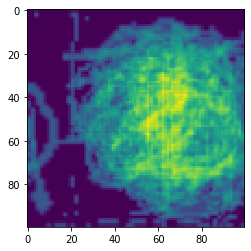

In [161]:
plt.imshow(np.mean(std_img, axis=2))

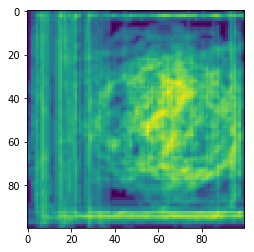

In [74]:
plt.imshow(np.mean(std_img, axis=2))

In [20]:
# Histogram
flattened = data.ravel()


# Digit clusterization

In [6]:
from __future__ import print_function

import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans 
import sklearn.datasets as ds
from sklearn.pipeline import Pipeline
#import plotly
from sklearn.decomposition import PCA

from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

#plotly.offline.init_notebook_mode()

from os import listdir
import os
from os.path import isfile, join


In [10]:
import umap

In [7]:
%matplotlib inline

In [11]:
%pwd

'/home/stanlee321/Desktop/DeepLearning/elecciones/actas'

In [13]:
def list_my_dir(mypath):
    return os.listdir(mypath)    


In [291]:
# Load the labeled Training data

path_train = "labels/trainData/train"
path_test = "labels/trainData/test"

classes = list_my_dir(path_train)


def create_train_test_data(my_data_path):

    labels_train = []
    images_train = []

    data_labels = list_my_dir(my_data_path)
    
    
    for label in data_labels:
        images_path = f"{my_data_path}/{label}/*.jpg"
        train_examples = glob.glob(images_path)
        for train_ex in train_examples:
            images_train.append(plt.imread(train_ex)[..., :3])
            labels_train.append(label)
    print("DONE!")
    return images_train, labels_train


X_train, y_train = create_train_test_data(path_train)
X_test, y_test = create_train_test_data(path_test)


DONE!
DONE!


In [292]:
print(len(X_train))
print(len(X_test))

701
180


In [293]:
def convert_to_numpy_images(images_list):
    # Crop every image to a square
    X = [utils.imcrop_tosquare(img_i) for img_i in images_list]
    # Then resize the square image to 100 x 100 pixels
    X = [resize(remove_color_and_add_filter(img_i), (100, 100)) for img_i in X]
    X = np.array(X).astype(np.float32)

    print(X.shape)
    return X

def convert_to_numpy_labels(labels_train):
    y = np.array(labels_train).astype(np.float32)
    print(y.shape)
    return y

def create_dataset(X_train, X_test, y_train, y_test):
    X_train = convert_to_numpy_images(X_train)
    X_test = convert_to_numpy_images(X_test)
    
    y_train = convert_to_numpy_labels(y_train)
    y_test = convert_to_numpy_labels(y_test)
    
    return X_train, X_test, y_train, y_test

In [294]:
X_train, X_test, y_train, y_test = create_dataset(X_train, X_test, y_train, y_test)


(701, 100, 100, 3)
(180, 100, 100, 3)
(701,)
(180,)


6.0


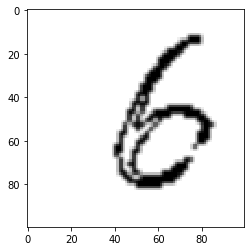

In [295]:
print(y_train[-1])
plt.imshow(X_train[-1])

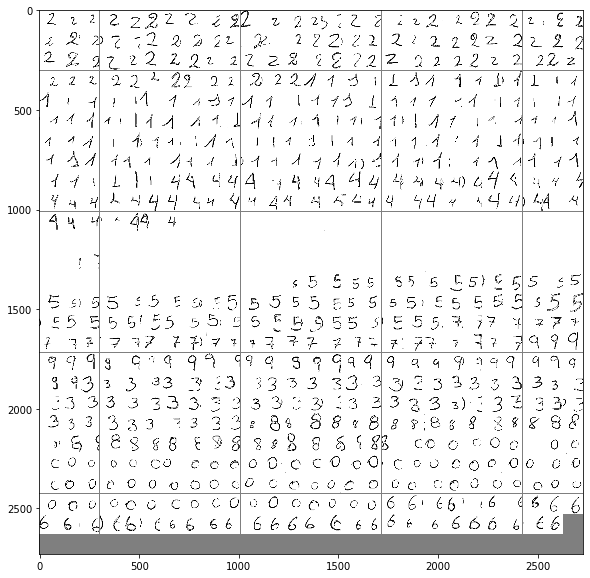

In [296]:
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(X_train))

In [314]:
def prepare_umap_data(numpy_array_train, numpy_array_test, y_train, y_test, classes):
    """
    (70, 100, 100, 3)
    (29, 100, 100, 3)

    """
    
    train_data = [convert_to_gray(image_i) for image_i in numpy_array_train]
    train_data = np.array(train_data).astype(np.float32)
    train_data = train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2])
    
    
    
    test_data = [convert_to_gray(image_i) for image_i in numpy_array_test]
    test_data = np.array(test_data).astype(np.float32)
    test_data = test_data.reshape(test_data.shape[0],test_data.shape[1]*test_data.shape[2])
    
    data = np.array(np.vstack([train_data, test_data]), dtype=np.float64) / 255.0
    
        
    target = np.append(y_train, y_test)

    return data, target, classes

def prepare_umap_data_unsupper(numpy_array_train):

    data = numpy_array_train.reshape(numpy_array_train.shape[0],
                                    numpy_array_train.shape[1] * numpy_array_train.shape[2]) / 255.0
    return data

In [262]:
data, target, classes= prepare_umap_data(X_train, X_test, y_train, y_test, classes)

In [263]:
data.shape

(881, 10000)

In [264]:
target.shape

(881,)

In [265]:
%%time
embedding = umap.UMAP(n_neighbors=10).fit_transform(data)

CPU times: user 6.16 s, sys: 46.9 ms, total: 6.2 s
Wall time: 5.37 s


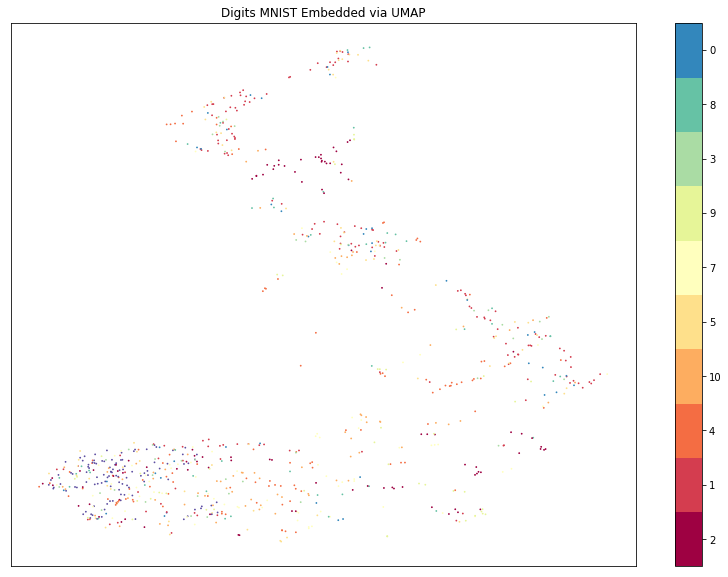

In [266]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.6, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Digits MNIST Embedded via UMAP');

In [ ]:
#Using Labels to Separate Classes (Supervised UMAP)

In [323]:
# Dimension reduction and clustering libraries
import umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [328]:
# Load 2k dataset.

imgs_p = read_final_data(filenames, 8000)



(8000, 100, 100)


In [329]:
data = prepare_umap_data_unsupper(imgs_p)
standard_embedding = umap.UMAP(random_state=42).fit_transform(data)

/home/stanlee321/.local/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../.local/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/utils.py", line 450:
<source missing, REPL/exec in use?>



In [330]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(data)

In [332]:
len(kmeans_labels)

8000

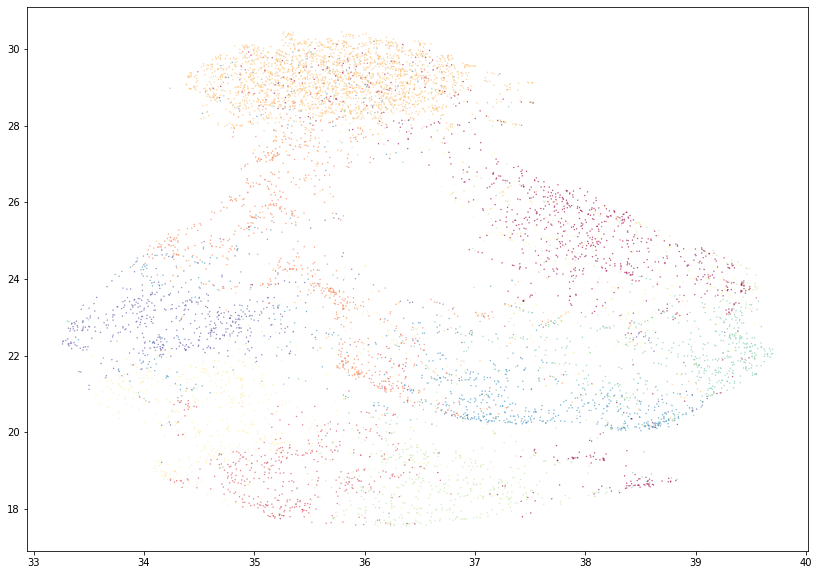

In [331]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');